In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5),std=(0.5,)) #Converting 0 to 1px to -1 to 1px
                              ])

dataset = MNIST(root='./data',train=True,transform=transform,download=True)

Label: 5
shape:  torch.Size([1, 28, 28])


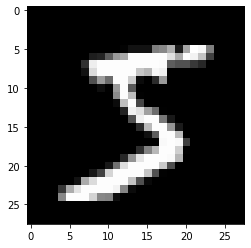

In [4]:
img,label = dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label)
print("shape: ",img.shape)

In [5]:
batch_size=100
train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=3,pin_memory=True)

In [6]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

torch.Size([100, 1, 28, 28])


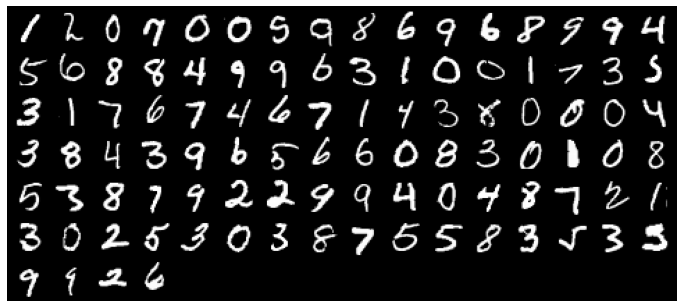

In [7]:
for images,labels in train_loader:
  print(images.shape)
  plt.figure(figsize=(12,10))
  plt.imshow(make_grid(denorm(images),nrow=16).permute(1,2,0))
  plt.axis('off')
  break

In [8]:
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [9]:
device = get_device()
device

device(type='cuda')

In [10]:
image_size = 784
hidden_size = 256
latent_size = 64

In [11]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())


In [12]:
D = D.to(device)

In [13]:
D

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [14]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [15]:
G

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [16]:
xb = torch.randn(2,64)
y = G(xb)
gen_imgs = y.reshape((-1, 28,28)).detach()

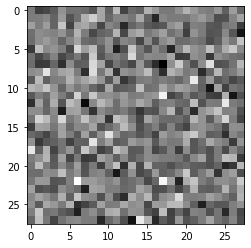

In [18]:
plt.imshow(denorm(gen_imgs[0]), cmap='gray');

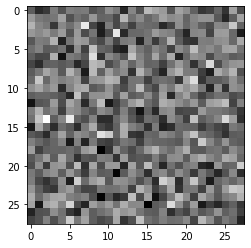

In [19]:
plt.imshow(denorm(gen_imgs[1]), cmap='gray');

In [20]:
G = G.to(device)

In [23]:
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [24]:
criterion = nn.BCELoss()

In [25]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [26]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = F.binary_cross_entropy(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [27]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

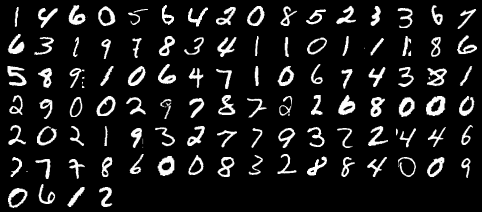

In [28]:
from IPython.display import Image
from torchvision.utils import save_image


# Save some real images
for images, _ in train_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=16)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


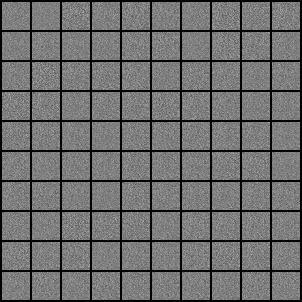

In [31]:
sample_vectors = torch.randn(100, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [32]:
num_epochs = 300
total_step = len(train_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size,-1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0309, g_loss: 4.1035, D(x): 1.00, D(G(z)): 0.03
Epoch [0/300], Step [400/600], d_loss: 0.0752, g_loss: 5.6310, D(x): 0.99, D(G(z)): 0.06
Epoch [0/300], Step [600/600], d_loss: 0.0325, g_loss: 5.0805, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.1229, g_loss: 5.4888, D(x): 0.96, D(G(z)): 0.04
Epoch [1/300], Step [400/600], d_loss: 0.2544, g_loss: 3.2874, D(x): 0.93, D(G(z)): 0.13
Epoch [1/300], Step [600/600], d_loss: 0.2618, g_loss: 4.7471, D(x): 0.95, D(G(z)): 0.14
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0792, g_loss: 4.3565, D(x): 0.98, D(G(z)): 0.05
Epoch [2/300], Step [400/600], d_loss: 0.9047, g_loss: 1.9502, D(x): 0.76, D(G(z)): 0.30
Epoch [2/300], Step [600/600], d_loss: 0.8823, g_loss: 2.3971, D(x): 0.80, D(G(z)): 0.24
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.5983, g_loss: 3.5357, D(x): 0.85, D(G(z)): 0.26
Epoch [3/300], Step [400/6

KeyboardInterrupt: ignored

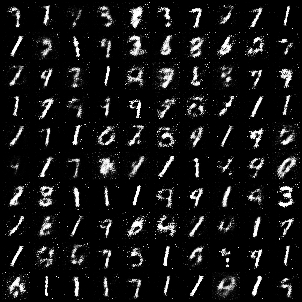

In [33]:
Image('./samples/fake_images-0050.png')

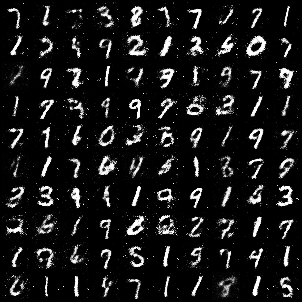

In [34]:
Image('./samples/fake_images-0083.png')

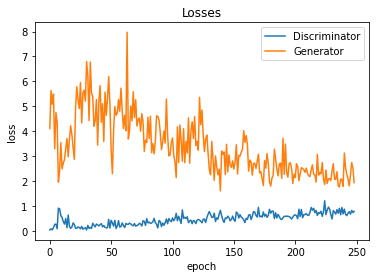

In [35]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

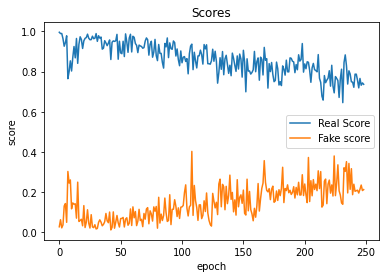

In [36]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');